In [7]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import time_series

custom_library_path_2 = os.path.abspath('util/gev')
sys.path.append(custom_library_path_2)

import data_processing#, vgam_loader

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

In [4]:
print(sys.path)

['/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/pre_processing/GEV', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python311.zip', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/lib-dynload', '', '/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/processing', '/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/util/gev']


In [2]:
# response value (or extreme value) taken from the storm landfall

vivian = time_series.tif_to_dataframe('data/time_series_rasters_storms_15h/5_VIVIAN.tif', '02_02_90')
climato_vivian = time_series.tif_to_dataframe('data/climatology/daily_without_storms/climatology_europe_2_2.tif', '02_02')

# drop rows with nan values
vivian = vivian.dropna()
climato_vivian = climato_vivian.dropna()

# wind values only
'''vivian = vivian.iloc[:,0]
climato_vivian = climato_vivian.iloc[:,0]
# export the frist column of each dataframe
vivian.to_csv('data/test/5_VIVIAN.csv')
climato_vivian.to_csv('data/test/max_winds_europe_2_2_cut.csv')'''

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries
vivian_small = vivian[(vivian['latitude'] >= lat_min) & (vivian['latitude'] <= lat_max) &
                 (vivian['longitude'] >= lon_min) & (vivian['longitude'] <= lon_max)]
climato_vivian_small = climato_vivian[(climato_vivian['latitude'] >= lat_min) & (climato_vivian['latitude'] <= lat_max) &
                    (climato_vivian['longitude'] >= lon_min) & (climato_vivian['longitude'] <= lon_max)]
# load the clean cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Add the cluster number to the vivian_small DataFrame
for idx, row in vivian_small.iterrows():
    lat, lon = row['latitude'], row['longitude']
    vivian_small.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    
# Add the cluster number to the climato_vivian_small DataFrame
for idx, row in climato_vivian_small.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/1747927560.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vivian_small.loc[idx, 'cluster_n'] = \
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/1747927560.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small.loc[idx, 'cluster_n'] = \


Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235


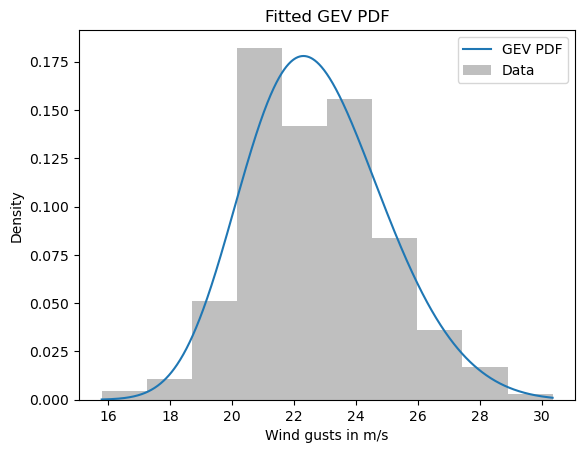

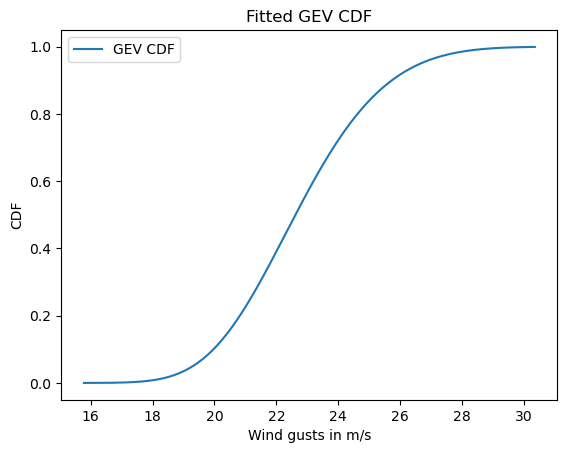

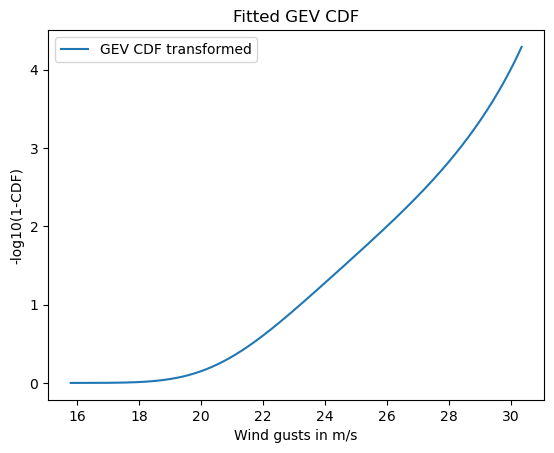

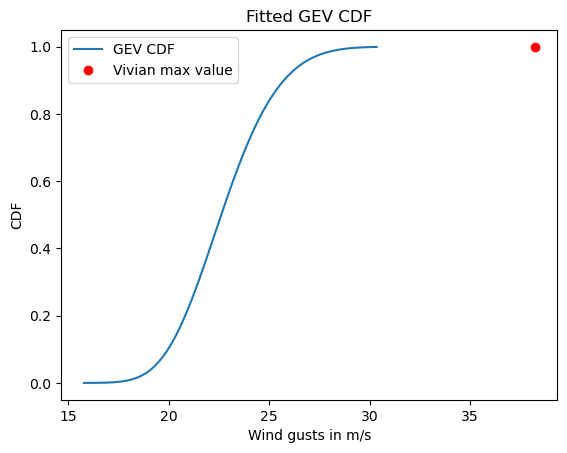

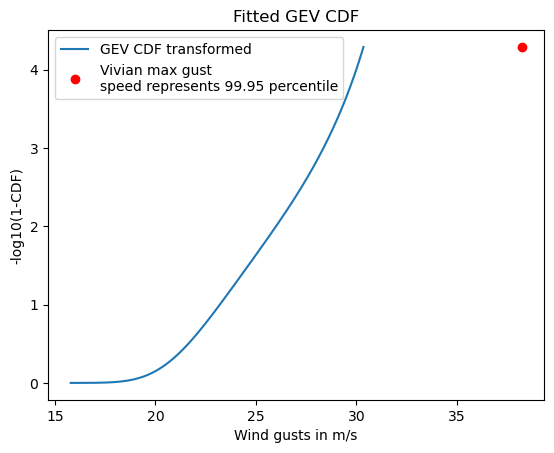

In [46]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

# Example data: yearly maxima with cluster number 0
cluster_number = 3

data = climato_vivian_small.groupby('cluster_n')
data = data.get_group(cluster_number)['wind_speed_02_02']
vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

# Fit the GEV distribution
shape, loc, scale = genextreme.fit(data, method="MLE")

print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

# Plot the PDF

x_vals = np.linspace(min(data), max(data), 1000)
pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

# tranform it with target - log10(1-CDF)
cdf_vals_tranformed = cdf_vals-np.log10(1-cdf_vals)

plt.plot(x_vals, pdf_vals, label="GEV PDF")
plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
plt.legend()
plt.title("Fitted GEV PDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("Density")
plt.show()

# Plot the CDF
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()


plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

# find the max value of the storm data (Vivian)
max_vivian = vivian_subset.max()

# find to what percentile the max_vivian value corresponds in the GEV distribution
percentile_CDF = cdf_vals[np.argmin(np.abs(x_vals - max_vivian))]
percentile_CDF_transformed = cdf_vals_tranformed[np.argmin(np.abs(x_vals - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals, cdf_vals, label="GEV CDF")
plt.plot(max_vivian, percentile_CDF, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals, cdf_vals_tranformed, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed, 'ro', label=f"Vivian max gust\nspeed represents {percentile_CDF*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

Cluster number: 0
Shape (ξ): 0.18141472036310008, Location (μ): 20.702205615905925, Scale (σ): 1.4698744394384435
Max Vivian Wind Gust: 34.298316129702584 m/s


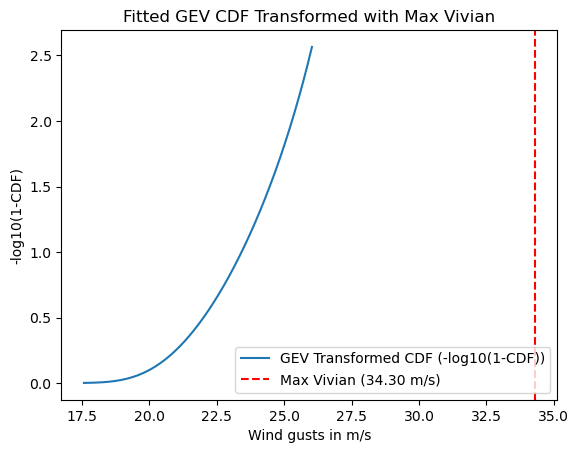

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 1
Shape (ξ): 0.11612598342162322, Location (μ): 19.955200168637298, Scale (σ): 1.6825143299767884
Max Vivian Wind Gust: 33.75238426429628 m/s


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/3687254706.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1 / (1 - cdf_max_vivian)


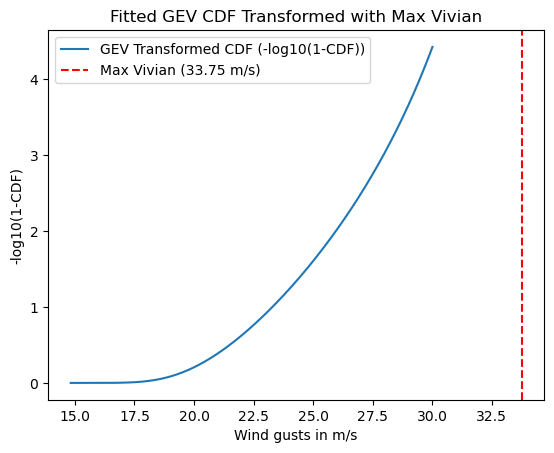

Return Period of Max Vivian Wind Gust: 238531798806.73 years
Cluster number: 2
Shape (ξ): -0.19783174819466295, Location (μ): 22.890531391724746, Scale (σ): 5.689100785070862
Max Vivian Wind Gust: 19.258854679788445 m/s


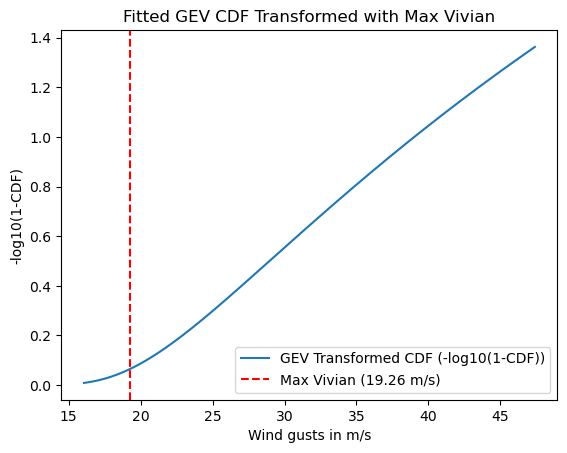

Return Period of Max Vivian Wind Gust: 1.16 years
Cluster number: 3
Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235
Max Vivian Wind Gust: 38.22601582905756 m/s


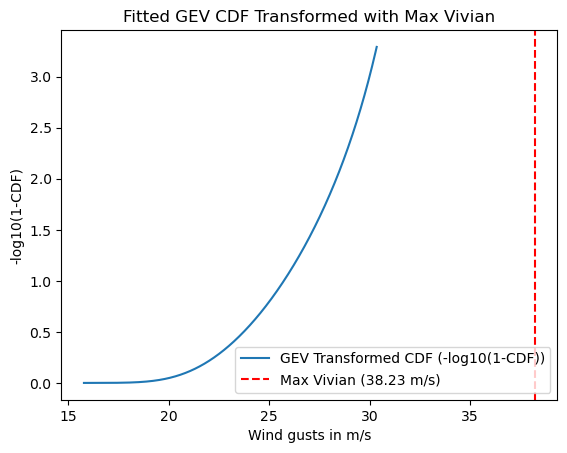

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 4
Shape (ξ): 0.0404206445384844, Location (μ): 19.153684118047842, Scale (σ): 1.3453245688380733
Max Vivian Wind Gust: 24.28176225614534 m/s


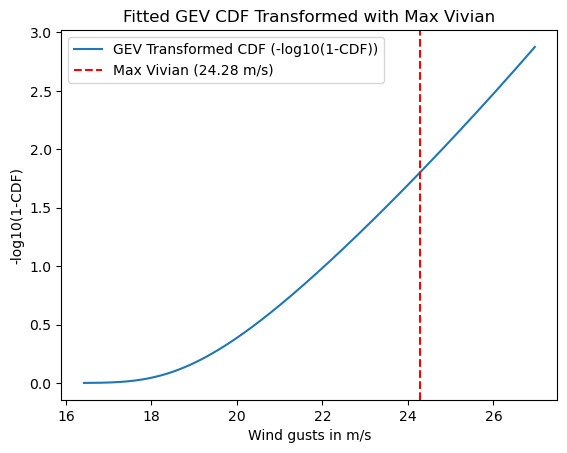

Return Period of Max Vivian Wind Gust: 63.28 years
Cluster number: 5
Shape (ξ): 0.22811279978723897, Location (μ): 21.62706520715929, Scale (σ): 4.148838213972128
Max Vivian Wind Gust: 22.349681795266378 m/s


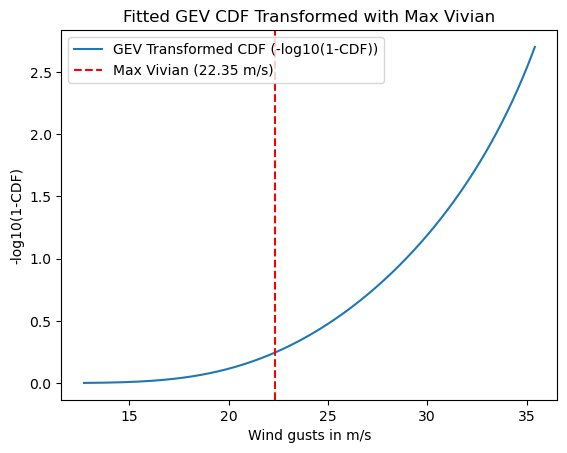

Return Period of Max Vivian Wind Gust: 1.76 years
Cluster number: 6
Shape (ξ): 0.13631561695063776, Location (μ): 28.478554587846205, Scale (σ): 2.559851064093988
Max Vivian Wind Gust: 41.357808735354645 m/s


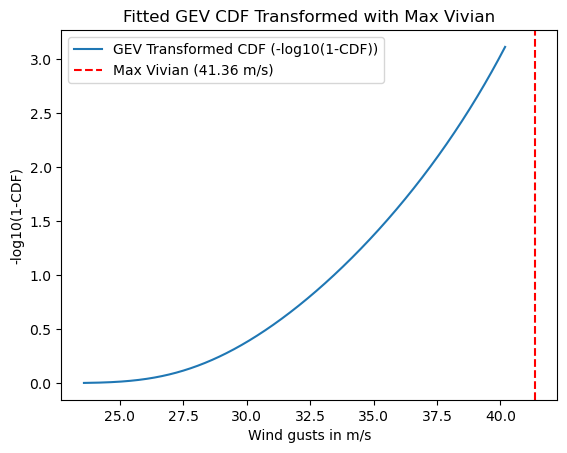

Return Period of Max Vivian Wind Gust: 4885.23 years
Cluster number: 7
Shape (ξ): 0.46584668317317984, Location (μ): 20.86121311065075, Scale (σ): 4.62502568248714
Max Vivian Wind Gust: 20.866552960303476 m/s


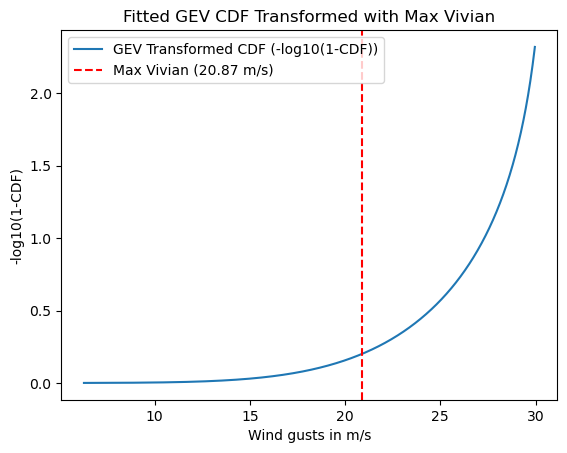

Return Period of Max Vivian Wind Gust: 1.58 years
Cluster number: 8
Shape (ξ): 0.19933047992257755, Location (μ): 16.706057222317263, Scale (σ): 2.882299945578085
Max Vivian Wind Gust: 21.190099104120073 m/s


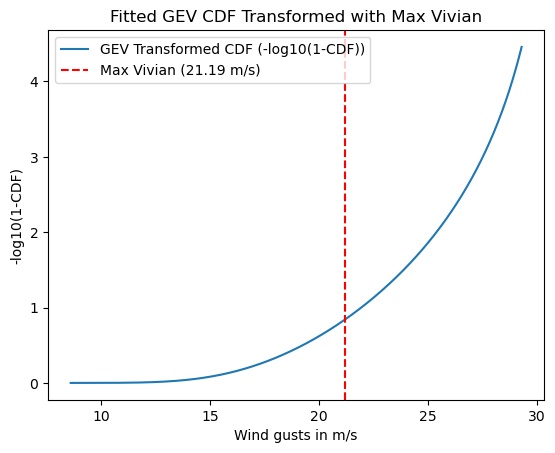

Return Period of Max Vivian Wind Gust: 6.95 years
Cluster number: 9
Shape (ξ): 0.09011051185802074, Location (μ): 21.38641636109024, Scale (σ): 2.0610503655485966
Max Vivian Wind Gust: 14.108033511690108 m/s


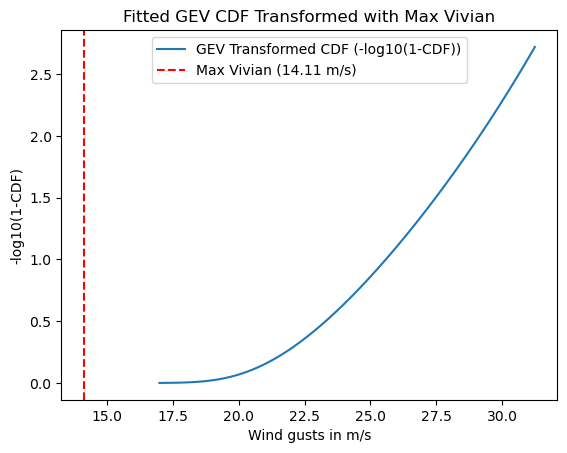

Return Period of Max Vivian Wind Gust: 1.00 years
Cluster number: 10
Shape (ξ): -0.23899428517843724, Location (μ): 19.14741305886404, Scale (σ): 2.3299939632823254
Max Vivian Wind Gust: 18.722119216402774 m/s


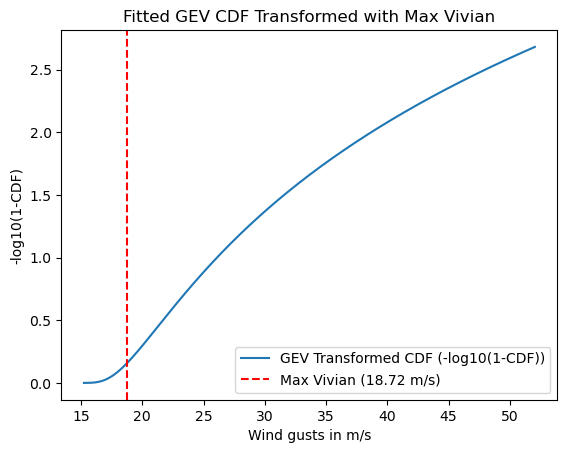

Return Period of Max Vivian Wind Gust: 1.43 years
Cluster number: 11
Shape (ξ): -0.0261144938313368, Location (μ): 25.78865991273984, Scale (σ): 3.9126564105787516
Max Vivian Wind Gust: 21.553775002208496 m/s


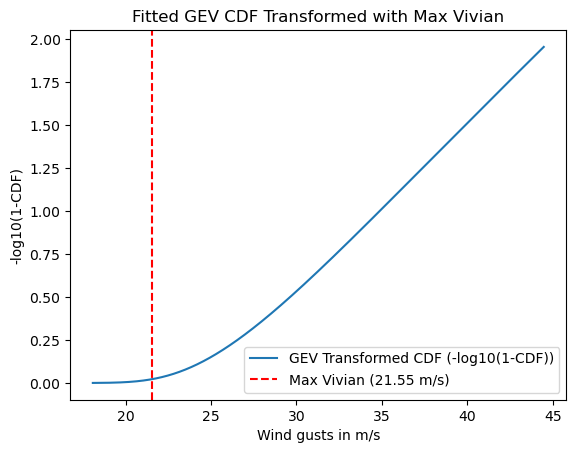

Return Period of Max Vivian Wind Gust: 1.05 years
Cluster number: 12
Shape (ξ): 0.24809232171845713, Location (μ): 28.575387528135934, Scale (σ): 5.242502087711989
Max Vivian Wind Gust: 27.908488798461615 m/s


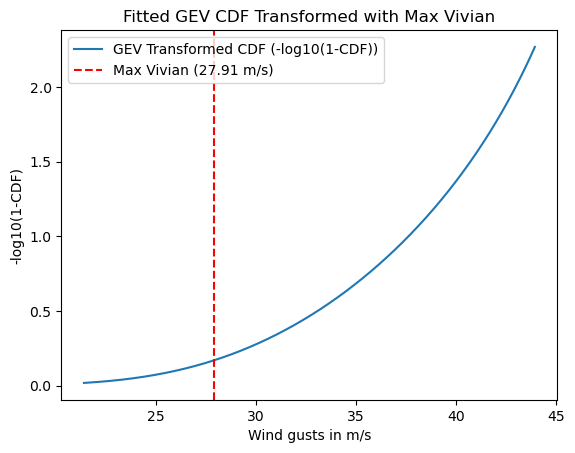

Return Period of Max Vivian Wind Gust: 1.47 years
Cluster number: 13
Shape (ξ): 2.5319377059301376, Location (μ): 29.5194842700934, Scale (σ): 2.5933680680405495
Max Vivian Wind Gust: 21.983497787535967 m/s


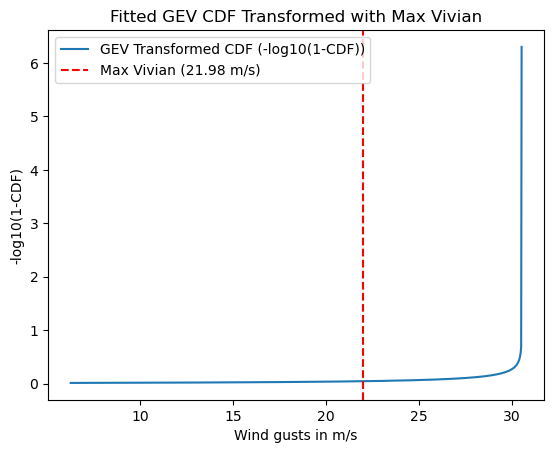

Return Period of Max Vivian Wind Gust: 1.11 years
Cluster number: 14
Shape (ξ): 0.029043941039239782, Location (μ): 23.693871607632083, Scale (σ): 3.113675988784606
Max Vivian Wind Gust: 19.999583060722568 m/s


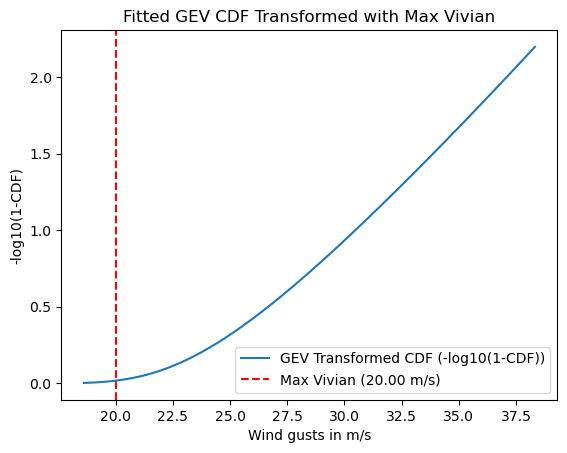

Return Period of Max Vivian Wind Gust: 1.04 years


In [7]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

all_plot = 'no'

# Example data: yearly maxima with cluster number 0
cluster_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for cluster_number in cluster_numbers:
    print('Cluster number:', cluster_number)
    data = climato_vivian_small.groupby('cluster_n')
    data = data.get_group(cluster_number)['wind_speed_02_02']
    vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

    # Fit the GEV distribution
    shape, loc, scale = genextreme.fit(data, method="MLE")

    print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

    # Max value of Vivian storm
    max_vivian = vivian_subset.max()
    print(f"Max Vivian Wind Gust: {max_vivian} m/s")

    # Plot the PDF
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
    cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

    # Transform CDF to -log10(1-CDF)
    cdf_vals_transformed = -np.log10(1 - cdf_vals)
    if all_plot == 'yes':
        plt.plot(x_vals, pdf_vals, label="GEV PDF")
        plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
        plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
        plt.legend()
        plt.title("Fitted GEV PDF with Max Vivian")
        plt.xlabel("Wind gusts in m/s")
        plt.ylabel("Density")
        plt.show()

    # Plot the transformed CDF
    plt.plot(x_vals, cdf_vals_transformed, label="GEV Transformed CDF (-log10(1-CDF))")
    plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
    plt.legend()
    plt.title("Fitted GEV CDF Transformed with Max Vivian")
    plt.xlabel("Wind gusts in m/s")
    plt.ylabel("-log10(1-CDF)")
    plt.show()

    # Compute return period for max_vivian
    cdf_max_vivian = genextreme.cdf(max_vivian, shape, loc=loc, scale=scale)
    return_period = 1 / (1 - cdf_max_vivian)
    print(f"Return Period of Max Vivian Wind Gust: {return_period:.2f} years")

In [45]:
test = xr.open_dataset('data/climatology/hourly_with_storms/climatology_europe_2_2.nc')
hourly_all = []
for i in range(0,24):
    test_test = test.sel(hour=i).to_dataframe().dropna()
    test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
    test_test = test_test.stack().reset_index()
    test_test = test_test.drop(columns=['level_2'])

    # Define latitude and longitude boundaries for Eastern and Southern Europe
    lat_min, lat_max = 35, 75
    lon_min, lon_max = -10, 25

    # Filter the DataFrame based on these boundaries

    test_test = test_test[(test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
                        (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)]
    for idx, row in test_test.iterrows():
        lat, lon = row['latitude'], row['longitude']
        test_test.loc[idx, 'cluster_n'] = \
            cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    hourly_all.append(test_test)
# Concatenate all DataFrames in the list into a single DataFrame
hourly_all_df = pd.concat(hourly_all, ignore_index=True)

# rename the column 0 by wind_speed_02_02
hourly_all_df_with = hourly_all_df.rename(columns={0: 'wind_speed_02_02'})
hourly_all_df_with['name'] = 'hourly_with_storms'

In [9]:
import pandas as pd
import xarray as xr

def process_hourly_climatology(dataset_path, cluster_data, name, lat_min=35, lat_max=75, lon_min=-10, lon_max=25):
    """
    Processes hourly climatology data and assigns cluster information.

    Parameters:
        dataset_path (str): Path to the NetCDF dataset.
        cluster_data (pd.DataFrame): DataFrame containing cluster data with 'Latitude', 'Longitude', and 'cluster_n' columns.
        name (str): Name to assign to the processed data (e.g., 'hourly_with_storms').
        lat_min (float): Minimum latitude boundary for filtering data.
        lat_max (float): Maximum latitude boundary for filtering data.
        lon_min (float): Minimum longitude boundary for filtering data.
        lon_max (float): Maximum longitude boundary for filtering data.

    Returns:
        pd.DataFrame: Processed DataFrame with wind speed and cluster information.
    """
    # Open dataset
    test = xr.open_dataset(dataset_path)
    hourly_all = []

    for i in range(24):
        # Select data for the current hour and preprocess
        test_test = test.sel(hour=i).to_dataframe().dropna()
        test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
        test_test = test_test.stack().reset_index()
        test_test = test_test.drop(columns=['level_2'])

        # Filter by latitude and longitude boundaries
        test_test = test_test[
            (test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
            (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)
        ]

        # Add cluster number
        for idx, row in test_test.iterrows():
            lat, lon = row['latitude'], row['longitude']
            cluster_value = cluster_data.loc[
                (cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'
            ]
            if not cluster_value.empty:
                test_test.loc[idx, 'cluster_n'] = cluster_value.values[0]

        hourly_all.append(test_test)

    # Concatenate all DataFrames
    hourly_all_df = pd.concat(hourly_all, ignore_index=True)

    # Rename column and add the provided name
    hourly_all_df_with = hourly_all_df.rename(columns={0: 'wind_speed_None'})
    hourly_all_df_with['name'] = name

    return hourly_all_df_with

In [10]:
# Assuming 'cluster_data' is already loaded as a DataFrame
dataset_path = 'data/climatology/hourly_without_storms/climatology_europe_2_2.nc'
test = process_hourly_climatology(dataset_path, cluster_data, name='hourly_without_storms')

In [55]:
test = xr.open_dataset('data/climatology/hourly_without_storms/climatology_europe_2_2.nc')
hourly_all = []
for i in range(0,24):
    test_test = test.sel(hour=i).to_dataframe().dropna()
    test_test = test_test.drop(columns=['hour', 'spatial_ref', 'band'])
    test_test = test_test.stack().reset_index()
    test_test = test_test.drop(columns=['level_2'])

    # Define latitude and longitude boundaries for Eastern and Southern Europe
    lat_min, lat_max = 35, 75
    lon_min, lon_max = -10, 25

    # Filter the DataFrame based on these boundaries

    test_test = test_test[(test_test['latitude'] >= lat_min) & (test_test['latitude'] <= lat_max) &
                        (test_test['longitude'] >= lon_min) & (test_test['longitude'] <= lon_max)]
    for idx, row in test_test.iterrows():
        lat, lon = row['latitude'], row['longitude']
        test_test.loc[idx, 'cluster_n'] = \
            cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
    hourly_all.append(test_test)
# Concatenate all DataFrames in the list into a single DataFrame
hourly_all_df = pd.concat(hourly_all, ignore_index=True)

# rename the column 0 by wind_speed_02_02
hourly_all_df_without = hourly_all_df.rename(columns={0: 'wind_speed_02_02'})

hourly_all_df_without['name'] = 'hourly_without_storms'

In [7]:
import pandas as pd

def process_daily_climatology(file_path, cluster_data, name, lat_min=35, lat_max=75, lon_min=-10, lon_max=25):
    """
    Processes daily climatology data and assigns cluster information.

    Parameters:
        file_path (str): Path to the TIFF file containing climatology data.
        cluster_data (pd.DataFrame): DataFrame containing cluster data with 'Latitude', 'Longitude', and 'cluster_n' columns.
        name (str): Name to assign to the processed data (e.g., 'daily_with_storms', 'daily_without_storms').
        lat_min (float): Minimum latitude boundary for filtering data.
        lat_max (float): Maximum latitude boundary for filtering data.
        lon_min (float): Minimum longitude boundary for filtering data.
        lon_max (float): Maximum longitude boundary for filtering data.

    Returns:
        pd.DataFrame: Processed DataFrame with cluster information.
    """
    # Load climatology data
    climatology_df = time_series.tif_to_dataframe(file_path)#, '02_02')
    climatology_df = climatology_df.dropna()

    # Filter by latitude and longitude boundaries
    climatology_df = climatology_df[
        (climatology_df['latitude'] >= lat_min) & (climatology_df['latitude'] <= lat_max) &
        (climatology_df['longitude'] >= lon_min) & (climatology_df['longitude'] <= lon_max)
    ]

    # Add cluster number
    for idx, row in climatology_df.iterrows():
        lat, lon = row['latitude'], row['longitude']
        cluster_value = cluster_data.loc[
            (cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'
        ]
        if not cluster_value.empty:
            climatology_df.loc[idx, 'cluster_n'] = cluster_value.values[0]

    # Assign name
    climatology_df['name'] = name

    return climatology_df

In [8]:
# Paths to the climatology data
file_path = 'data/climatology/daily_with_storms/climatology_europe_2_2.tif'

# Load cluster data as a DataFrame
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Process data for daily_with_storms
test_2 = process_daily_climatology(
    file_path, cluster_data, name='daily_with_storms'
)

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_without_storms.loc[idx, 'cluster_n'] = \
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_with_storms.loc[idx, 'cluster_n'] = \


Cluster number: 3
Shape (ξ): 0.1890843670434622, Location (μ): 21.868480614147536, Scale (σ): 2.107041196823235
Max Vivian Wind Gust: 38.22601582905756 m/s


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_with_storms['name'] = 'daily_with_storms'
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climato_vivian_small_without_storms['name'] = 'daily_without_storms'


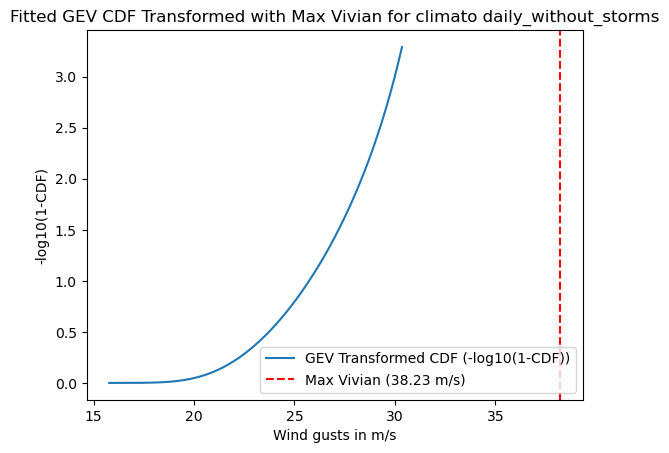

/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_8770/2777266924.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1 / (1 - cdf_max_vivian)


Return Period of Max Vivian Wind Gust: inf years
Cluster number: 3
Shape (ξ): 0.3294756591162554, Location (μ): 25.397486488921807, Scale (σ): 3.363615723016351
Max Vivian Wind Gust: 38.22601582905756 m/s


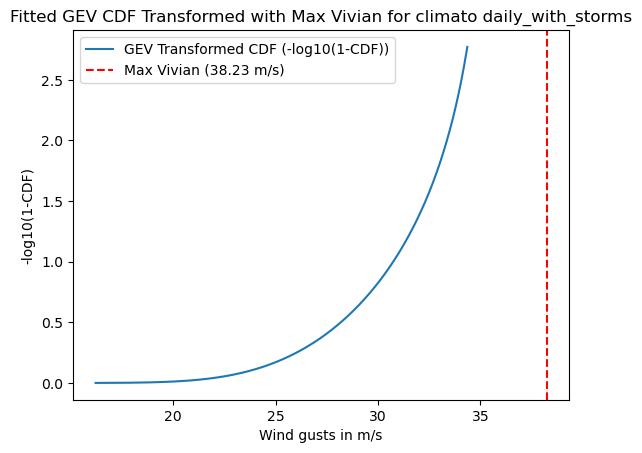

Return Period of Max Vivian Wind Gust: inf years
Cluster number: 3
Shape (ξ): 0.1608528101264684, Location (μ): 18.669109728351636, Scale (σ): 3.3956253689812095
Max Vivian Wind Gust: 38.22601582905756 m/s


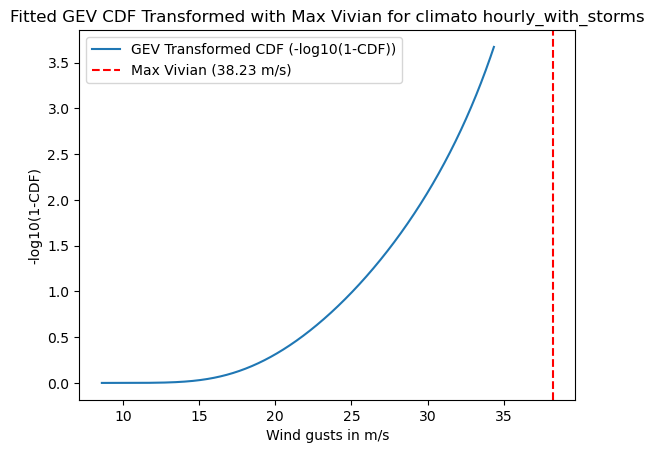

Return Period of Max Vivian Wind Gust: 11099080.36 years
Cluster number: 3
Shape (ξ): 0.20839599819832832, Location (μ): 17.539917280086982, Scale (σ): 2.8185461764971356
Max Vivian Wind Gust: 38.22601582905756 m/s


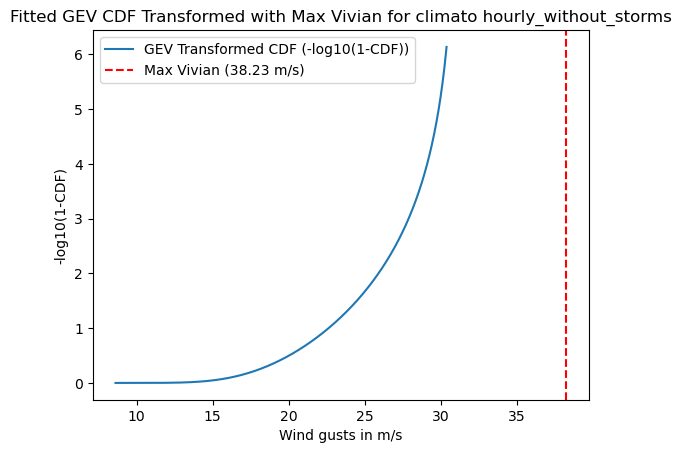

Return Period of Max Vivian Wind Gust: inf years


In [56]:
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt

all_plot = 'no'

# response value (or extreme value) taken from the storm landfall

climato_vivian_without_storms = time_series.tif_to_dataframe('data/climatology/daily_without_storms/climatology_europe_2_2.tif', '02_02')
climato_vivian_with_storms = time_series.tif_to_dataframe('data/climatology/daily_with_storms/climatology_europe_2_2.tif', '02_02')

# drop rows with nan values
climato_vivian_without_storms = climato_vivian_without_storms.dropna()
climato_vivian_with_storms = climato_vivian_with_storms.dropna()

# Define latitude and longitude boundaries for Eastern and Southern Europe
lat_min, lat_max = 35, 75
lon_min, lon_max = -10, 25

# Filter the DataFrame based on these boundaries

climato_vivian_small_without_storms = climato_vivian_without_storms[(climato_vivian_without_storms['latitude'] >= lat_min) & (climato_vivian_without_storms['latitude'] <= lat_max) &
                    (climato_vivian_without_storms['longitude'] >= lon_min) & (climato_vivian_without_storms['longitude'] <= lon_max)]
climato_vivian_small_with_storms = climato_vivian_with_storms[(climato_vivian_with_storms['latitude'] >= lat_min) & (climato_vivian_with_storms['latitude'] <= lat_max) &
                    (climato_vivian_with_storms['longitude'] >= lon_min) & (climato_vivian_with_storms['longitude'] <= lon_max)]

# load the clean cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')

# Add the cluster number to the climato_vivian_small DataFrame
for idx, row in climato_vivian_small_without_storms.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small_without_storms.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]
for idx, row in climato_vivian_small_with_storms.iterrows():
    lat, lon = row['latitude'], row['longitude']
    climato_vivian_small_with_storms.loc[idx, 'cluster_n'] = \
        cluster_data.loc[(cluster_data['Latitude'] == lat) & (cluster_data['Longitude'] == lon), 'cluster_n'].values[0]

climato_vivian_small_with_storms['name'] = 'daily_with_storms'
climato_vivian_small_without_storms['name'] = 'daily_without_storms'

dataset = []
dataset.append(climato_vivian_small_without_storms)
dataset.append(climato_vivian_small_with_storms)
dataset.append(hourly_all_df_with)
dataset.append(hourly_all_df_without)


# Example data: yearly maxima with cluster number 0
cluster_number = 3
for data in dataset:
    data_name = data['name'].iloc[0]
    print('Cluster number:', cluster_number)
    data = data.groupby('cluster_n')
    data = data.get_group(cluster_number)['wind_speed_02_02']
    vivian_subset = vivian_small[vivian_small['cluster_n'] == cluster_number]['wind_speed_02_02_90']

    # Fit the GEV distribution
    shape, loc, scale = genextreme.fit(data, method="MLE")

    print(f"Shape (ξ): {shape}, Location (μ): {loc}, Scale (σ): {scale}")

    # Max value of Vivian storm
    max_vivian = vivian_subset.max()
    print(f"Max Vivian Wind Gust: {max_vivian} m/s")

    # Plot the PDF
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf_vals = genextreme.pdf(x_vals, shape, loc=loc, scale=scale)
    cdf_vals = genextreme.cdf(x_vals, shape, loc=loc, scale=scale)

    # Transform CDF to -log10(1-CDF)
    cdf_vals_transformed = -np.log10(1 - cdf_vals)
    if all_plot == 'yes':
        plt.plot(x_vals, pdf_vals, label="GEV PDF")
        plt.hist(data, bins=10, density=True, alpha=0.5, color="gray", label="Data")
        plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
        plt.legend()
        plt.title("Fitted GEV PDF with Max Vivian")
        plt.xlabel("Wind gusts in m/s")
        plt.ylabel("Density")
        plt.show()

    # Plot the transformed CDF
    plt.plot(x_vals, cdf_vals_transformed, label="GEV Transformed CDF (-log10(1-CDF))")
    plt.axvline(max_vivian, color='red', linestyle='--', label=f"Max Vivian ({max_vivian:.2f} m/s)")
    plt.legend()
    plt.title(f"Fitted GEV CDF Transformed with Max Vivian for climato {data_name}")
    plt.xlabel("Wind gusts in m/s")
    plt.ylabel("-log10(1-CDF)")
    plt.savefig(f'pre_processing/GEV/figures/gev_transformed_{data_name}.png')
    plt.show()

    # Compute return period for max_vivian
    cdf_max_vivian = genextreme.cdf(max_vivian, shape, loc=loc, scale=scale)
    return_period = 1 / (1 - cdf_max_vivian)
    print(f"Return Period of Max Vivian Wind Gust: {return_period:.2f} years")

In [ ]:
# now calculate the moving location with climatology 1 day before and 1 day after the storm



/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_1619/974471234.py:5: RuntimeWarning: divide by zero encountered in log10
  cdf_vals_tranformed_extended = cdf_vals_extended-np.log10(1-cdf_vals_extended)


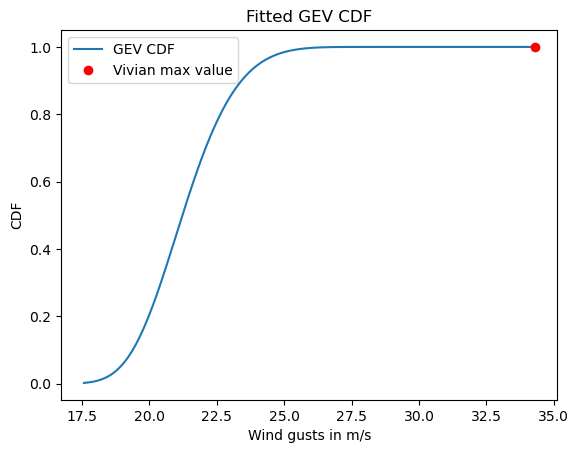

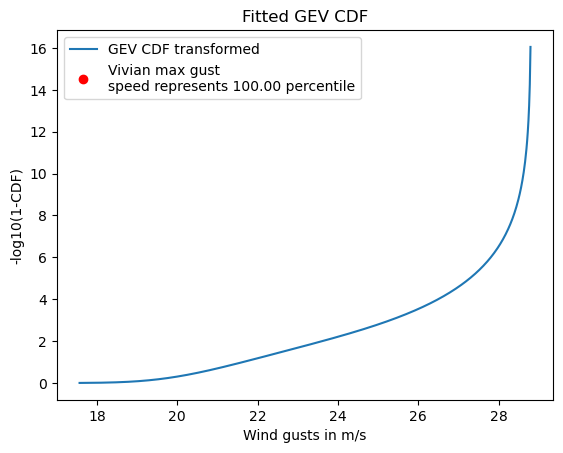

In [36]:
# now expand the x_vals to the whole range of the maxima
x_vals_extended = np.linspace(min(data), max(vivian_subset), 1000)
cdf_vals_extended = genextreme.cdf(x_vals_extended, shape, loc=loc, scale=scale)
# tranform it with target - log10(1-CDF)
cdf_vals_tranformed_extended = cdf_vals_extended-np.log10(1-cdf_vals_extended)

percentile_extended = cdf_vals_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]
percentile_CDF_transformed_extended = cdf_vals_tranformed_extended[np.argmin(np.abs(x_vals_extended - max_vivian))]

# plot them on the CDF and CDF transformed
plt.plot(x_vals_extended, cdf_vals_extended, label="GEV CDF")
plt.plot(max_vivian, percentile_extended, 'ro', label="Vivian max value")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("CDF")
plt.show()

plt.plot(x_vals_extended, cdf_vals_tranformed_extended, label="GEV CDF transformed")
plt.plot(max_vivian, percentile_CDF_transformed_extended, 'ro', label=f"Vivian max gust\nspeed represents {percentile_extended*100:.2f} percentile")
plt.legend()
plt.title("Fitted GEV CDF")
plt.xlabel("Wind gusts in m/s")
plt.ylabel("-log10(1-CDF)")
plt.show()

In [33]:
# calculate the return period of the storm
return_period = 1/(1-percentile_extended)
print(f"The return period of the storm Vivian is {return_period:.2f} years")

The return period of the storm Vivian is inf years


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_1619/963461105.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return_period = 1/(1-percentile_extended)


In [ ]:
# import cluster data 
cluster_data = pd.read_csv('pre_processing/cluster/number_of_clusters/cleaned_cluster_15_v1.csv')
file_path = 'data/climatology/daily_with_storms/climatology_europe_2_2.tif'